# Model subclass

*This is a companion notebook for the excellent book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) ([code provided by François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)).* 

## Setup

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#### Rewriting our previous example as a subclassed model

**A simple subclassed model**

In [28]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [29]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [30]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 36.3067 - output_1_loss: 0.3358 - output_2_loss: 35.9709 - output_1_mean_absolute_error: 0.5018 - output_2_accuracy: 0.0711


#### Beware: What subclassed models don't support

### Mixing and matching different components

**Creating a Functional model that includes a subclassed model**

In [31]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**Creating a subclassed model that includes a Functional model**

In [32]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### Remember: Use the right tool for the job

## Using built-in training and evaluation loops

**The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`**

In [33]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2950 - accuracy: 0.9129 - val_loss: 0.1440 - val_accuracy: 0.9583
Epoch 2/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1656 - accuracy: 0.9523 - val_loss: 0.1242 - val_accuracy: 0.9676
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1100 - accuracy: 0.9721


### Writing your own metrics

**Implementing a custom metric by subclassing the `Metric` class**

In [34]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [35]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2944 - accuracy: 0.9128 - rmse: 7.1830 - val_loss: 0.1680 - val_accuracy: 0.9492 - val_rmse: 7.3523
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1637 - accuracy: 0.9538 - rmse: 7.3535 - val_loss: 0.1208 - val_accuracy: 0.9672 - val_rmse: 7.3989
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1135 - accuracy: 0.9701 - rmse: 7.4333


### Using callbacks

#### The EarlyStopping and ModelCheckpoint callbacks

**Using the `callbacks` argument in the `fit()` method**

In [36]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2928 - accuracy: 0.9133 - val_loss: 0.1478 - val_accuracy: 0.9574
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1672 - accuracy: 0.9529 - val_loss: 0.1180 - val_accuracy: 0.9663
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1406 - accuracy: 0.9624 - val_loss: 0.1176 - val_accuracy: 0.9693
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1245 - accuracy: 0.9679 - val_loss: 0.1175 - val_accuracy: 0.9717
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1164 - accuracy: 0.9713 - val_loss: 0.1073 - val_accuracy: 0.9755
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1089 - accuracy: 0.9735 - val_loss: 0.1145 - val_accuracy: 0.9741
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1054 - accuracy: 0.9750 - val_loss: 0.1143 - val_accuracy:

In [37]:
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

**Creating a custom callback by subclassing the `Callback` class**

In [38]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2937 - accuracy: 0.9127 - val_loss: 0.1441 - val_accuracy: 0.9600
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1636 - accuracy: 0.9538 - val_loss: 0.1332 - val_accuracy: 0.9642
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1379 - accuracy: 0.9627 - val_loss: 0.1149 - val_accuracy: 0.9709
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1247 - accuracy: 0.9671 - val_loss: 0.1013 - val_accuracy: 0.9759
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1161 - accuracy: 0.9710 - val_loss: 0.1080 - val_accuracy: 0.9749
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1108 - accuracy: 0.9734 - val_loss: 0.1096 - val_accuracy: 0.9775
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1040 - accuracy: 0.9755 - val_loss: 0.1143 - val_accuracy:

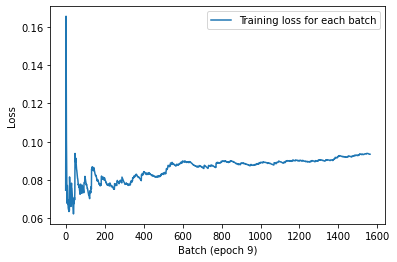

In [39]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

In [41]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

2022-03-31 14:41:28.457683: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at summary_kernels.cc:65 : PERMISSION_DENIED: /train; Read-only file system


PermissionDeniedError: /train; Read-only file system [Op:CreateSummaryFileWriter]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

## Writing your own training and evaluation loops

### Training versus inference

### Low-level usage of metrics

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

In [ ]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

### A complete training and evaluation loop

**Writing a step-by-step training loop: the training step function**

In [ ]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

**Writing a step-by-step training loop: resetting the metrics**

In [ ]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

**Writing a step-by-step training loop: the loop itself**

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

**Writing a step-by-step evaluation loop**

In [ ]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Make it fast with tf.function

**Adding a `tf.function` decorator to our evaluation-step function**

In [ ]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Leveraging fit() with a custom training loop

**Implementing a custom training step to use with `fit()`**

In [ ]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

## Summary